[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvarogg777/colabCompression/blob/master/Compress_Lab4.ipynb)

In [16]:
from matplotlib import pyplot as plt
import numpy as np
!git clone https://github.com/alvarogg777/colabCompression.git
!mv colabCompression/*.ipynb . && rm -r colabCompression && jupyter nbconvert --to script *.ipynb && mv Compress_Lab1.txt lab1.py && mv Compress_Lab2.txt lab2.py && mv Compress_Lab3.txt lab3.py && rm *.ipynb && ls

Cloning into 'colabCompression'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 100 (delta 60), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (100/100), 2.51 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (60/60), done.
[NbConvertApp] Converting notebook Compress_Lab1.ipynb to script
[NbConvertApp] Writing 3495 bytes to Compress_Lab1.txt
[NbConvertApp] Converting notebook Compress_Lab2.ipynb to script
[NbConvertApp] Writing 4573 bytes to Compress_Lab2.txt
[NbConvertApp] Converting notebook Compress_Lab3.ipynb to script
[NbConvertApp] Writing 4914 bytes to Compress_Lab3.txt
lab1.py  lab2.py  lab3.py  lena512.bmp	__pycache__  sample_data


In [0]:
import os
lines=[]
def removeExclamationsAndDownloads():
  for file in os.listdir():
    if(file.endswith('.py')):
      with open(file) as f:
        for line in f.readlines():
          if(line[0]!='!' and not line.startswith('files.download')):
            lines.append(line)
      os.remove(file)
      with open(file,'w') as f:
        for line in lines:
          f.write(line)
removeExclamationsAndDownloads()

In [0]:
from lab3 import lena, ll2_norm,lh2_norm,hl2_norm,hh2_norm,lh1_norm,hl1_norm,hh1_norm,lh2_q,hl2_q,hh2_q,lh1_q,hl1_q,hh1_q,lena_q
from lab3 import normalize 
from lab3 import entropies as haar_entropies
from lab3 import compressRates as haar_compressRates
from lab1 import psnr_entropy,getDistortion,shannonEntropy

In [0]:
def find5maxmin(input_matrix):
  freqDict={}
  uniques=np.unique(input_matrix)
  for value in uniques:
    freqDict[value]=(input_matrix==value).sum() / np.size(input_matrix)

  min5=sorted(freqDict.items(),key=lambda item: item[1])[0:5]
  max5=sorted(freqDict.items(),key=lambda item: item[1])[::-1][0:5]
  return max5,min5
max5=dict(find5maxmin(lena)[0])
min5=dict(find5maxmin(lena)[1])

In [20]:
print(max5,min5)

{154: 0.010387420654296875, 155: 0.01026153564453125, 156: 0.010196685791015625, 153: 0.009960174560546875, 157: 0.009510040283203125} {25: 3.814697265625e-06, 235: 3.814697265625e-06, 238: 3.814697265625e-06, 244: 3.814697265625e-06, 245: 3.814697265625e-06}


In [0]:
from heapq import heappush, heappop, heapify
import pandas as pd
class huffmanCode():
  def __init__(self,input_matrix):
    self.huffmanDict={}
    self.codes=pd.DataFrame({'symbol':[],'weights':[],'huffmanCode':[]})
    self.setHuffmanDict(input_matrix)
    self.setCodes()
  def setHuffmanDict(self,input_matrix):
    freqDict={}
    uniques=np.unique(input_matrix)
    for value in uniques:
      self.huffmanDict[value]=(input_matrix==value).sum() / np.size(input_matrix)
  def setCodes(self):
    """Huffman encode the given dict mapping symbols to weights"""
    heapQueue = [[wt, [sym, ""]] for sym, wt in self.huffmanDict.items()]#heap contains all the symbols (Nfreq, N elements in our queue)
    heapify(heapQueue)
    oldLen=len(heapQueue)
    first=heapQueue[0]
    last=heapQueue[1]
    while len(heapQueue) > 1:#we keep dequeing until len==1, having one element with [freq 1 and all the [symbol,code]]
        lo = heappop(heapQueue)#take first lowest frequency from the heap
        hi = heappop(heapQueue)#take second
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]#starts putting 0 as huffcode to first symbol
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heapQueue, [lo[0] + hi[0]] + lo[1:] + hi[1:])#here pushes to the heap sortly by weight: (sum of their weights),[symbol1,code1],[symbol2,code2]
#         if(len(heapQueue)==2): #print this condition if you want to have an idea on how it gets reduced
#           print(heapQueue[0])
#           print(heapQueue[1])
        #first iteration pushes: [[7.62939453125e-06, [25, '0'], [245, '1']]]
    sortCodes=sorted(heappop(heapQueue)[1:], key=lambda p: (len(p[1]),p))
    for index,p in enumerate(sortCodes):
      self.codes.loc[index]=[p[1], p[0],self.huffmanDict[p[0]]]
huffman=huffmanCode(lena)#lets run it on lena

In [22]:
print(len(huffman.codes))
huffman.codes.tail()

215


,huffmanCode,symbol,weights
210,01101010011001100,245.0,0.000004
211,011010100110011010,25.0,0.000004
212,011010100110011011,235.0,0.000004
213,011010100110011100,238.0,0.000004
214,011010100110011101,244.0,0.000004


https://scicomp.stackexchange.com/questions/10757/implement-the-huffman-code-in-python-or-numpy

Let's prove that priority queue algorithm works fine by taking a look at the weights

In [23]:
for i in max5:
  print(i)
  found=huffman.codes[huffman.codes.symbol==i]
  print(found)
  print('len code:',len(found.huffmanCode.iloc[0]))
  
for i in min5:
  print(i)
  found=huffman.codes[huffman.codes.symbol==i]
  print(found)
  print('len code:',len(found.huffmanCode.iloc[0]))  

154
   huffmanCode  symbol   weights
66     1111010   154.0  0.010387
len code: 7
155
   huffmanCode  symbol   weights
67     1110111   155.0  0.010262
len code: 7
156
   huffmanCode  symbol   weights
68     1110110   156.0  0.010197
len code: 7
153
   huffmanCode  symbol  weights
65     1110100   153.0  0.00996
len code: 7
157
   huffmanCode  symbol  weights
69     1110000   157.0  0.00951
len code: 7
25
            huffmanCode  symbol   weights
211  011010100110011010    25.0  0.000004
len code: 18
235
            huffmanCode  symbol   weights
212  011010100110011011   235.0  0.000004
len code: 18
238
            huffmanCode  symbol   weights
213  011010100110011100   238.0  0.000004
len code: 18
244
            huffmanCode  symbol   weights
214  011010100110011101   244.0  0.000004
len code: 18
245
           huffmanCode  symbol   weights
210  01101010011001100   245.0  0.000004
len code: 17


build a Huffman code tree and, therefore, associate codewords to Haar
wavelet coefficients in your **decomposition, depending on the probabilities
of occurrence (or histogram of coefficients) (thus on the quantized haar)**

In [0]:
ll2_h=huffmanCode(ll2_norm).codes
lh2_qh=huffmanCode(lh2_q).codes#lh2_q 7 quantization on lh2
hl2_qh=huffmanCode(hl2_q).codes
hh2_qh=huffmanCode(hh2_q).codes
lh1_qh=huffmanCode(lh1_q).codes
hl1_qh=huffmanCode(hl1_q).codes
hh1_qh=huffmanCode(hh1_q).codes
lena_qh=huffmanCode(lena_q).codes

In [25]:
def avgLength(df_codes):
  codes=df_codes['huffmanCode']
  codes=codes.apply(lambda x: len(x))#length codes
  codes=codes*df_codes['weights']
  return codes.sum()
sh_ll2_qh=avgLength(ll2_h)
sh_lh2_qh=avgLength(lh2_qh)
sh_hl2_qh=avgLength(hl2_qh)
sh_hh2_qh=avgLength(hh2_qh)
sh_lh1_qh=avgLength(lh1_qh)
sh_hl1_qh=avgLength(hl1_qh)
sh_hh1_qh=avgLength(hh1_qh)
# sh_lena_qh=avgLength(lena_qh)
lengths=[sh_ll2_qh,sh_lh2_qh,sh_hl2_qh,sh_hh2_qh,sh_lh1_qh,sh_hl1_qh,sh_hh1_qh]
# def computeTotalEntropy(array,original_matrix):
#   np.size()
#   for i in array:
    
sh_lena_qh=(sh_ll2_qh)*np.size(ll2_h)/np.size(lena)
print('avg length codework (bits/symbol) huffman ll2:',sh_ll2_qh)
print('avg length codework (bits/symbol) huffman lh2 quantized:',sh_lh2_qh)
print('avg length codework (bits/symbol) huffman hl2 quantized:',sh_hl2_qh)
print('avg length codework (bits/symbol) huffman hh2 quantized:',sh_hh2_qh)
print('avg length codework (bits/symbol) huffman lh1 quantized:',sh_lh1_qh)
print('avg length codework (bits/symbol) huffman hl1 quantized:',sh_hl1_qh)
print('avg length codework (bits/symbol) huffman hh1 quantized:',sh_hh1_qh)
print('avg length codework (bits/symbol) huffman lena quantized:',sh_lena_qh)
entropies_hq=np.array([sh_ll2_qh,sh_lh2_qh,sh_hl2_qh,sh_hh2_qh,sh_lh1_qh,sh_hl1_qh,sh_hh1_qh,sh_lena_qh])

avg length codework (bits/symbol) huffman ll2: 11.27996826171875
avg length codework (bits/symbol) huffman lh2 quantized: 4.2303466796875
avg length codework (bits/symbol) huffman hl2 quantized: 3.87640380859375
avg length codework (bits/symbol) huffman hh2 quantized: 3.073974609375
avg length codework (bits/symbol) huffman lh1 quantized: 2.141754150390625
avg length codework (bits/symbol) huffman hl1 quantized: 2.1814117431640625
avg length codework (bits/symbol) huffman hh1 quantized: 1.68988037109375
avg length codework (bits/symbol) huffman lena quantized: 0.37526170047931373


**Compute the total Huffman entropy compression ratio between
quantized and non-quantized images.**
Now she's asking to compute the non-quantized huffmanCodes and its entropies to compare ratios.

In [0]:
ll2_h=huffmanCode(ll2_norm).codes#lh2_norm normalized lh2
lh2_h=huffmanCode(lh2_norm).codes
hl2_h=huffmanCode(hl2_norm).codes
hh2_h=huffmanCode(hh2_norm).codes
lh1_h=huffmanCode(lh1_norm).codes
hl1_h=huffmanCode(hl1_norm).codes
hh1_h=huffmanCode(hh1_norm).codes
lena_h=huffmanCode(normalize(lena)).codes
sh_ll2_h=avgLength(ll2_h)
sh_lh2_h=avgLength(lh2_h)
sh_hl2_h=avgLength(hl2_h)
sh_hh2_h=avgLength(hh2_h)
sh_lh1_h=avgLength(lh1_h)
sh_hl1_h=avgLength(hl1_h)
sh_hh1_h=avgLength(hh1_h)
sh_lena_h=avgLength(lena_h)
entropies_h=np.array([sh_ll2_h,sh_lh2_h,sh_hl2_h,sh_hh2_h,sh_lh1_h,sh_hl1_h,sh_hh1_h,sh_lena_h])

In [29]:
haar_entropies_h=np.concatenate((entropies_h,entropies_hq))#8 bits per symbol on original
print(haar_entropies_h[8:])#non-quantized haar w/ huffman
print(haar_entropies_h[8:])#quantized

[11.27996826  4.23034668  3.87640381  3.07397461  2.14175415  2.18141174
  1.68988037  0.3752617 ]
[11.27996826  4.23034668  3.87640381  3.07397461  2.14175415  2.18141174
  1.68988037  0.3752617 ]


In [30]:
print(haar_entropies[8:])#non-quantized haar
print(haar_entropies[8:])

[1.12492164e+01 4.19588299e+00 3.84070036e+00 3.02343600e+00
 5.86869705e+00 5.39444857e+00 4.80708200e+00 2.33618557e-05]
[1.12492164e+01 4.19588299e+00 3.84070036e+00 3.02343600e+00
 5.86869705e+00 5.39444857e+00 4.80708200e+00 2.33618557e-05]


The entropy has reduced a lot applying huffman encoding compared to our previous results from uniform quantizer on the haar waveler from the previous lab.

Here we can see how the bits per symbol remains stable, but its fairly improved

In [33]:
haar_compressRates_h=8/haar_entropies_h#original image with 8bps
print(haar_compressRates_h[:8])
print(haar_compressRates_h[8:])
# print(-np.concatenate((entropies_h,entropies_hq)))
print(haar_compressRates[:8])
print(haar_compressRates[8:])

[0.70922185 0.9791357  1.07195315 1.1577469  1.35516256 1.47609422
 1.65387406 1.0712074 ]
[ 0.70922185  1.89109797  2.06376848  2.60249384  3.73525598  3.66734984
  4.73406292 21.31845587]
[0.71116064 0.98293684 1.07504928 1.16343267 1.36316459 1.48300608
 1.66421126 1.3062994 ]
[7.11160643e-01 1.90663086e+00 2.08295344e+00 2.64599615e+00
 1.36316459e+00 1.48300608e+00 1.66421126e+00 3.42438550e+05]


The compress ratios remains the same on lower subbands and over the full haar, but it increases 3x on the upper subband. 


In [0]:
!apt-get install libgraphicsmagick++1-dev libboost-python-dev libopenjp2-7-dev libopenjp2-tools
!wget https://www.imagemagick.org/download/ImageMagick.tar.gz
!tar xf ImageMagick.tar.gz
!cd ImageMagick-7* && ./configure && make && make install
!ldconfig /usr/local/lib

In [37]:
!pip install glymur pgmagick
import glymur, pgmagick
# from pgmagick import Image
jp2file = glymur.data.nemo()# on glymur.data there's more jp2 to test
# nemo=plt.imread(jp2file)
# plt.imshow(nemo)
# print(jp2file)
# nemoImg=Image(jp2file)
# nemoImg.write('nemo.jpeg')  # Output Image

    100% |████████████████████████████████| 3.4MB 6.0MB/s 
    100% |████████████████████████████████| 368kB 16.4MB/s 
  Running setup.py bdist_wheel for glymur ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/5d/4e/87/97ddd8c62b87e39ffae13c25602d0047faa96ff659021249c0
  Running setup.py bdist_wheel for pgmagick ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/02/51/cf/782c678ad1be3168fc0aa06e48959dbf0b64994b4e47ae796e
Successfully built glymur pgmagick


In [0]:
# https://www.howtogeek.com/109369/how-to-quickly-resize-convert-modify-images-from-the-linux-terminal/

In [127]:
!cp /usr/local/lib/python3.6/dist-packages/glymur/data/nemo.jp2 im_nemo.jp2
!convert -quality 100 im_nemo.jp2 nemo100.jpg #default is 92 quality on convert command, np.max == 255, min==0 --> R=8
!convert -quality 80 im_nemo.jp2 nemo80.jpg #default is 92 quality
!convert -quality 60 im_nemo.jp2 nemo60.jpg #default is 92 quality
!convert -quality 40 im_nemo.jp2 nemo40.jpg #default is 92 quality
!convert -quality 20 im_nemo.jp2 nemo20.jpg #default is 92 quality
!ls -lh | grep nemo

-rw-r--r--  1 root root    1.1M Oct 17 00:17 im_nemo.jp2
-rw-r--r--  1 root root    4.0M Oct 17 00:17 nemo100.jpg
-rw-r--r--  1 root root    260K Oct 17 00:17 nemo20.jpg
-rw-r--r--  1 root root    403K Oct 17 00:17 nemo40.jpg
-rw-r--r--  1 root root    531K Oct 17 00:17 nemo60.jpg
-rw-r--r--  1 root root    815K Oct 17 00:17 nemo80.jpg


nemo20.jpg (1456, 2592, 3)
nemo40.jpg (1456, 2592, 3)
nemo60.jpg (1456, 2592, 3)
nemo80.jpg (1456, 2592, 3)
nemo100.jpg (1456, 2592, 3)
quality results order shown below [20, 40, 60, 80, 100]
shannon [7.534597622903865, 7.556165037064537, 7.575730389554403, 7.583205069547927, 7.5752645448369025]
psnr [39.36020296628485, 39.34778925924137, 39.33655850576535, 39.33227560272506, 39.33682556913799]


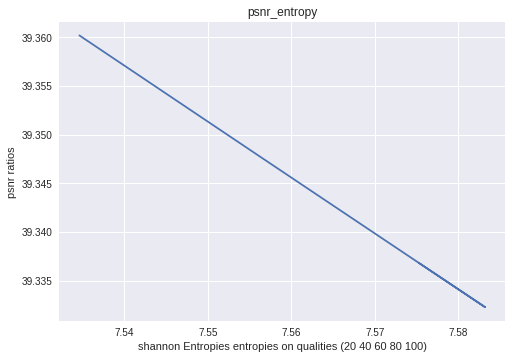

In [136]:
# nemo100=plt.imread('nemo100.jpg')#supposedly to be lossless
# plt.imshow(nemo100)
import re
def psnr_entropy(file_name,format):
  list_files_aux={}
  list_files={}
  for file in os.listdir():
    if(file.endswith(format) and file.startswith(file_name)):
      quality=int(re.findall(r'\d+',file)[0])
      list_files_aux[quality]=file
  for key in sorted(list_files_aux):
    list_files[key]=list_files_aux[key]
  entropies=[]
  psnr_ratios=[]
  for index,file in enumerate(list_files.values()):
    image=plt.imread(file)
    print(file,image.shape)
    entropies.append(shannonEntropy(image))
    psnr_ratios.append(10*np.log10((255**2)/entropies[index]))
  plt.figure()
  plt.title('psnr_entropy')
  plt.xlabel('shannon Entropies entropies on qualities ('+' '.join([str(key) for key in sorted(list_files_aux)])+')')
  plt.ylabel('psnr ratios')
  plt.plot(entropies,psnr_ratios)
  print('quality results order shown below',sorted(list_files_aux))
  print('shannon',entropies)
  print('psnr',psnr_ratios)
psnr_entropy('nemo','jpg')

The higher PSNR ratio the better..??

Our results show that the lower the quality we do the conversion from jp2 to jpeg the better PSNR ratio and entropy (higher and lower, respectively). But with so little difference. **LUCA, try with other pics perhaps** 

In [133]:
!convert -quality 100 im_nemo.jp2 nemo100.jp2 #default is 92 quality, np.max == 255, min==0 --> R=8
!convert -quality 80 im_nemo.jp2 nemo80.jp2 #default is 92 quality
!convert -quality 60 im_nemo.jp2 nemo60.jp2 #default is 92 quality
!convert -quality 40 im_nemo.jp2 nemo40.jp2 #default is 92 quality
!convert -quality 20 im_nemo.jp2 nemo20.jp2 #default is 92 quality
!ls -lh |grep 0.jp2

-rw-r--r--  1 root root    2.3M Oct 17 00:18 nemo100.jp2
-rw-r--r--  1 root root    8.2K Oct 17 00:18 nemo20.jp2
-rw-r--r--  1 root root    855K Oct 17 00:18 nemo40.jp2
-rw-r--r--  1 root root    2.0M Oct 17 00:18 nemo60.jp2
-rw-r--r--  1 root root    2.2M Oct 17 00:18 nemo80.jp2


nemo20.jp2 (1456, 2592, 3)
nemo40.jp2 (1456, 2592, 3)
nemo60.jp2 (1456, 2592, 3)
nemo80.jp2 (1456, 2592, 3)
nemo100.jp2 (1456, 2592, 3)
quality results order shown below [20, 40, 60, 80, 100]
shannon [7.4456523917940185, 7.581842765149187, 7.576709246558625, 7.564249858905024, 7.5639570527806175]
psnr [39.41177604012347, 39.333055872317466, 39.33599739190342, 39.34314495037648, 39.3433130655865]


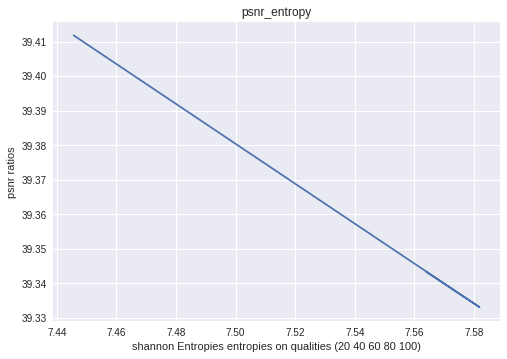

In [137]:
psnr_entropy('nemo','jp2')

In [0]:
# !identify -list format


# **Export as latex project**

In [0]:
from google.colab import files
!apt install pandoc
!pip install pandoc
!git clone https://github.com/alvarogg777/colabCompression.git
!jupyter nbconvert colabCompression/Compress_Lab4.ipynb --to latex
!zip colabCompression/Compress_Lab4*
files.download('colabCompression/Compress_Lab4_files.zip')